# Introduction

This term project explores a data set about new particle formation (NPF) that has been measured on different days at the Hyytiälä forestry research station. Different models for binary classication and multi-class classification are explored and based on the findings, the best models are selected. The binary classifier classifies the data points to either `event` or `nonevent` and the multi-class classifier tries to do more detailed predictions classifying to events `Ia`, `Ib`, `II` and `nonevent`.

# Data Exploration

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.feature_selection
import sklearn.metrics as sm

from IPython.display import Markdown, display
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.svm import SVC

npf_train = pd.read_csv("data/npf_train.csv")

def is_event(row):
    return 0 if row['class4'] == 'nonevent' else 1

def preprocess(npf):
    training_labels = pd.DataFrame(npf['class4'])
    training_labels['class2'] = training_labels.apply(lambda row: is_event(row), axis=1)
    
    data = npf.drop(['date', 'id', 'partlybad', 'class4'], axis=1)
    data = data.drop([column for column in npf.columns if 'std' in column], axis=1)

    # Removing .means from all column names
    data_columns = [column[:-5] for column in data.columns]

    normalized_data = scale(data)
    
    training_data = pd.DataFrame(normalized_data, columns=data_columns)
    
    return training_data, training_labels

training_data, training_labels = preprocess(npf_train)

The NPF data contains 50 different features. A row in the data set corresponds to a summary of measurements in a given day: the mean and standard deviation of the measurements of the day are recorded. In this analysis the standard deviations are omitted and we will be focusing solely on the daily mean values as those will most certainly have the biggest impact. The columns `id`, `date` and `partlybad` are also omitted as the `id` just gives the number of the row, `partlybad` has the same value for every row and we assume for simplicity that the year or time of the year does not affect NPF events making the `date` column obsolete. The values are also normalized to take into account differences in the units of the features.

## Visualizing and looking at data

Now for the sake of being sure our data is correct we display some of the features of the data set. After the preprocessing there should be exactly 50 different feature columns with a mean of around zero and a standard deviation of around one. There should also be training labels for the binary classification and multi-class classification.

### Summary of the training data

Bellow are the features that are now included in the preprocessed training data set:

In [56]:
', '.join(training_data.columns) + '; TOTAL: ' + str(len(training_data.columns)) + ' columns'

'CO2168, CO2336, CO242, CO2504, Glob, H2O168, H2O336, H2O42, H2O504, H2O672, H2O84, NET, NO168, NO336, NO42, NO504, NO672, NO84, NOx168, NOx336, NOx42, NOx504, NOx672, NOx84, O3168, O342, O3504, O3672, O384, Pamb0, PAR, PTG, RGlob, RHIRGA168, RHIRGA336, RHIRGA42, RHIRGA504, RHIRGA672, RHIRGA84, RPAR, SO2168, SWS, T168, T42, T504, T672, T84, UV_A, UV_B, CS; TOTAL: 50 columns'

The following table shows some of the above listed feature columns. Only measurements from altitude of 168 metres are displayed.

In [49]:
unique_features = [
    'CO2168', 
    'Glob', 
    'H2O168', 
    'NET', 
    'NO168', 
    'NOx168', 
    'O3168', 
    'Pamb0',
    'PAR', 
    'PTG', 
    'RGlob', 
    'RHIRGA168', 
    'RPAR', 
    'SO2168', 
    'SWS', 
    'T168', 
    'UV_A', 
    'UV_B', 
    'CS'
]

training_data[unique_features].describe()

,CO2168,Glob,H2O168,NET,NO168,NOx168,O3168,Pamb0,PAR,PTG,RGlob,RHIRGA168,RPAR,SO2168,SWS,T168,UV_A,UV_B,CS
count,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,430.000000,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02,4.300000e+02
mean,-9.501444e-16,-1.920944e-16,3.511403e-17,1.755702e-16,0.000000,6.506423e-17,-5.742177e-16,-3.474223e-15,4.027786e-16,-4.131062e-18,-4.131062e-17,-5.680211e-16,-2.065531e-16,5.576934e-17,3.420520e-15,-1.239319e-17,5.576934e-17,3.304850e-17,-8.468678e-17
std,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00,1.001165e+00
min,-1.875618e+00,-1.491853e+00,-1.675358e+00,-2.061073e+00,-0.373462,-8.596639e-01,-3.263946e+00,-3.291238e+00,-1.498089e+00,-1.021236e+00,-1.690143e+00,-2.052959e+00,-1.521800e+00,-6.899580e-01,-1.091802e+01,-3.093412e+00,-1.583963e+00,-1.370987e+00,-1.317582e+00
25%,-7.355876e-01,-9.481972e-01,-8.176048e-01,-8.974616e-01,-0.269602,-5.967159e-01,-6.631075e-01,-6.053005e-01,-9.420220e-01,-3.971853e-01,-9.164222e-01,-8.289480e-01,-7.316662e-01,-4.936262e-01,4.573200e-02,-7.686702e-01,-9.095202e-01,-9.429522e-01,-6.954363e-01
50%,-7.665427e-02,2.595395e-02,-2.051390e-01,3.219668e-02,-0.203654,-2.911239e-01,-9.731835e-03,4.152682e-02,3.674895e-02,-8.620618e-02,5.982532e-02,-3.622154e-02,-3.854662e-02,-3.487622e-01,2.571542e-01,1.626540e-01,1.144485e-01,-7.128886e-02,-2.610193e-01
75%,6.136010e-01,9.036262e-01,7.082398e-01,8.785990e-01,-0.030419,2.506595e-01,6.771524e-01,6.550514e-01,8.433892e-01,5.937846e-02,8.624004e-01,9.476029e-01,5.059836e-01,1.806152e-02,3.912139e-01,8.022425e-01,8.937891e-01,8.028325e-01,4.095185e-01
max,3.602466e+00,1.772479e+00,3.090199e+00,1.994198e+00,16.757193,8.545549e+00,3.861881e+00,2.832383e+00,1.720520e+00,1.264096e+01,2.557978e+00,1.935028e+00,5.543624e+00,9.096254e+00,7.631300e-01,1.833670e+00,1.678620e+00,2.376226e+00,5.750172e+00


From the summary of the training data labels we can see that the training set contains 215 nonevents and 215 events. A balanced training data set is important for getting unbiased predictions.

In [41]:
display(Markdown(training_labels.describe(include="all", percentiles=[]).to_markdown()))

|        | class4   |     class2 |
|:-------|:---------|-----------:|
| count  | 430      | 430        |
| unique | 4        | nan        |
| top    | nonevent | nan        |
| freq   | 215      | nan        |
| mean   | nan      |   0.5      |
| std    | nan      |   0.500582 |
| min    | nan      |   0        |
| 50%    | nan      |   0.5      |
| max    | nan      |   1        |

### Feature comparison

Next we have a scatter plot from a few random columns to get an idea of what the data looks like.

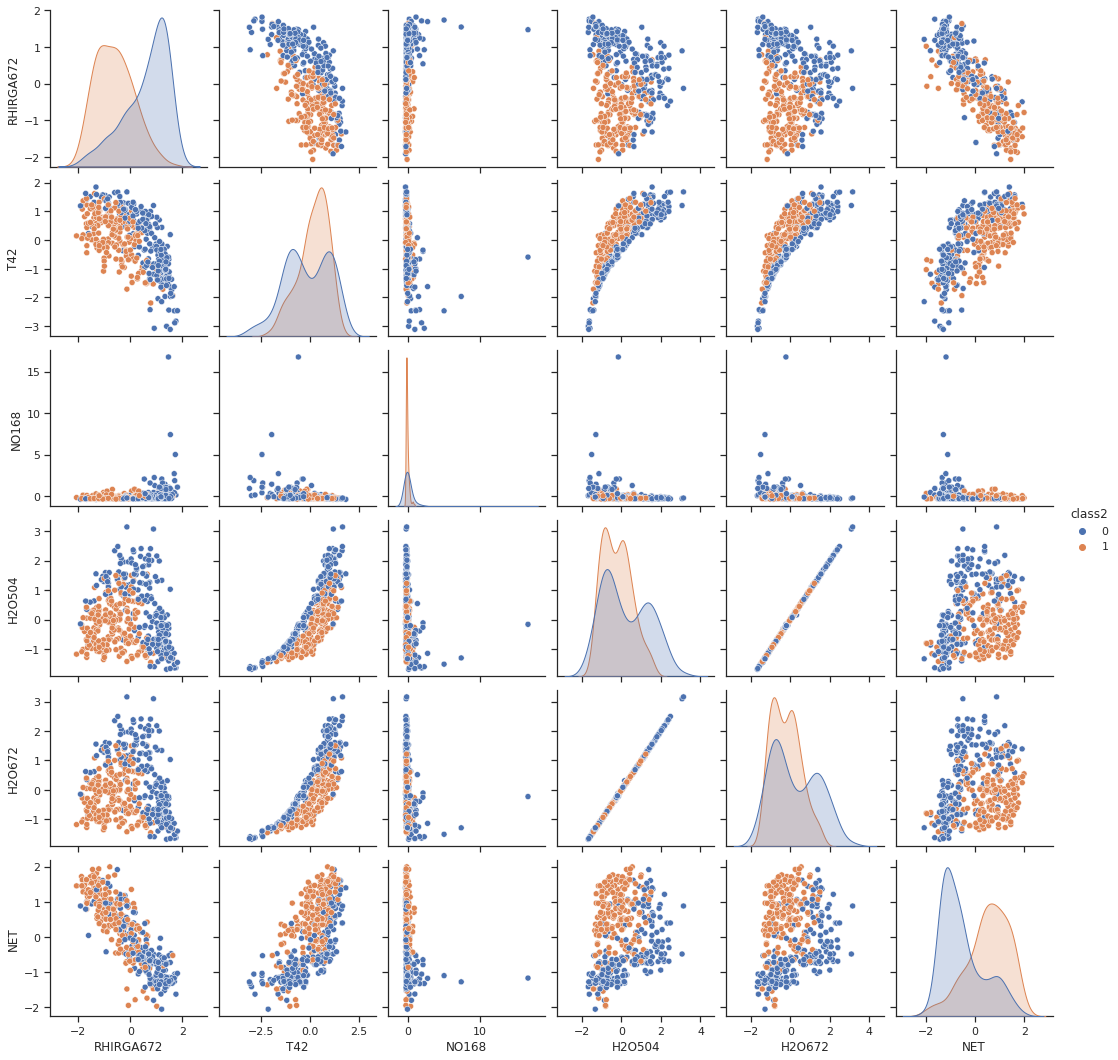

In [15]:
np.random.seed(1)
col_idx = np.random.randint(0,50,6)
df_small = training_data.iloc[:,col_idx]
df_small = df_small.join(training_labels['class2'])

sns.set_theme(style="ticks")
sns.pairplot(df_small, hue="class2")

First impression of the data is that some features are quite nicely separated between event and nonevent days (for example NET, RHIRGA672) whereas some others seem to have similar distributions for both events and nonevents (NOx168). Also, some variables are strongly correlating (H2O504 x H2O672). This correlation was expected as all H20 features measure the concentration of H2O at different altitudes. The same correlation most likely happens with different NOx and RHIRGA values as well. Air temperature (T42) and water concentration seem to have an interesting nonlinear correlation.

Another look at the correlations between features:

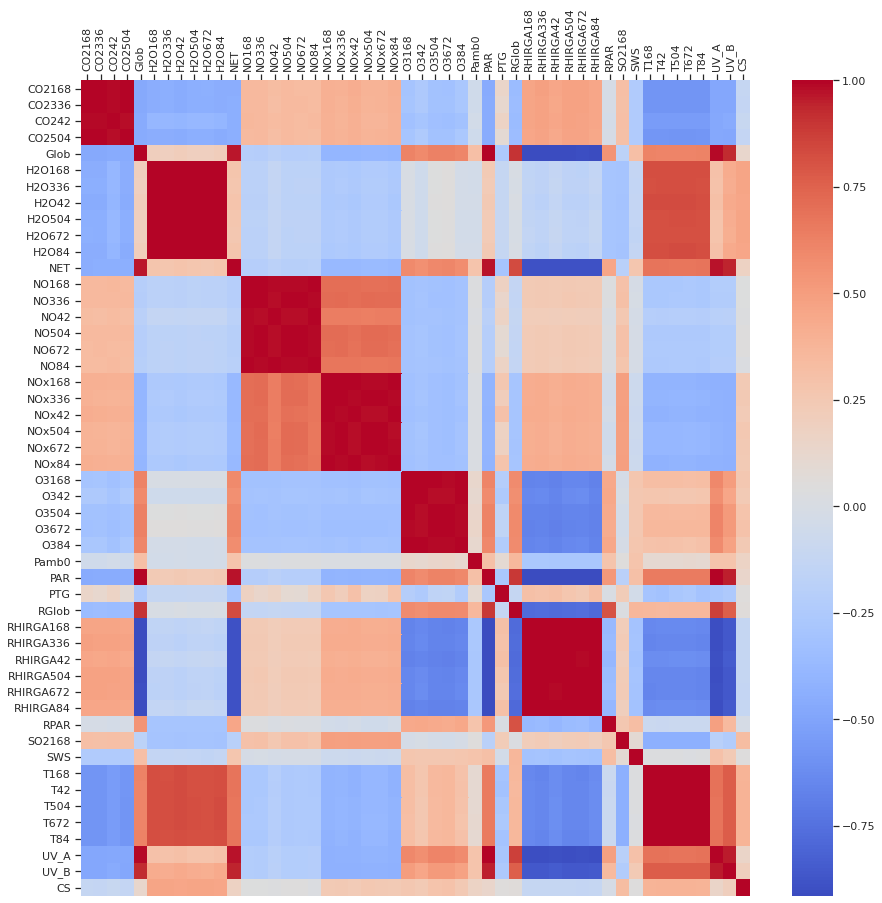

In [8]:
corr = training_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, cmap="coolwarm")
ax.xaxis.tick_top() # x axis on top
plt.xticks(rotation=90)
ax.xaxis.set_label_position('top')

All features measuring the same concentration are strongly correlated. Also, water and temperature are correlated as was hinted in the previous scatter plot and some other features are correlated as well.

# Binary Classifier

## Unsupervised learning

Before training the model with previously known labels, let's use PCA to see if it's able to see some patterns in the data and cluster the samples accordingly. We can also use PCA to reduce the dimensionality of the data in feature selection.

[0.44996106 0.17302662]


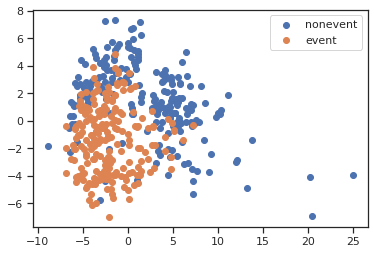

In [8]:
pca2 = PCA(2)
components2 = pca2.fit_transform(training_data)

plt.scatter(components2[y==0,0], components2[y==0,1], label="nonevent")
plt.scatter(components2[y==1,0], components2[y==1,1], label="event")
plt.legend()

print(pca2.explained_variance_ratio_)

## Supervised learning

### Feature selection with selectKBest

Feature selection reduces training time and it makes the model less complex which reduces the risk of overfitting. It's also generally good practise to have the simplest possible model that achieves a good accuracy. Let's use SelectKBest for selecting 20 features with best k scores.

In [57]:
selector = SelectKBest(k=20)
x_selected = selector.fit_transform(training_data, training_labels['class2'])
idx = selector.get_support(indices=True)

# Divide the training data (all features) into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_data, training_labels['class2'], test_size=0.5, random_state=0)

# Divide the training data (20 best features) into training and validation sets
X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(x_selected, training_labels['class2'], test_size=0.5, random_state=0)

10-fold cross validation for logistic regression with and without the feature selection:

In [67]:
cv_all = cross_val_score(LogisticRegression(), training_data, training_labels['class2'], cv=10).mean()
cv_top_20 = cross_val_score(LogisticRegression(), x_selected, training_labels['class2'], cv=10).mean()

# Print cross validation score for logistic regression on all features
print('Score with all features:\t' + str(cv_all))

# Print the cross validation score for logistic regression using 20 best features
print('Score with top 20 features:\t' + str(cv_top_20))

Score with all features:	0.855813953488372
Score with top 20 features:	0.8162790697674419


There is a slight drop with accuracy when using only the 20 highest k scoring features with logistic regression compared to using all features. Let's see how using only the best feature affects the cross validation score. We get the following result:

In [68]:
# Select only one feature
selector = SelectKBest(k=1)
x_selected_one = selector.fit_transform(training_data, training_labels['class2'])

# Get index of the best feature
idx = selector.get_support(indices=True)

best_name = training_data.columns[idx][0]

best_score = cross_val_score(LogisticRegression(), x_selected_one, training_labels['class2'], cv=10).mean()

print('Score with only ' + best_name + ':\t' + str(best_score))

Score with only RHIRGA84:	0.7906976744186046


Observation: Cross validation score of 0.79 achieved using just RHIRGA84 feature and logistic regression so using only the best feature still gives reasonably good results.

### Dimensionality reduction using PCA

Let's see if the cross validation score is improved by first reducing the dimensionality to 10 using PCA.

In [69]:
pca_10 = PCA(10)
components_10 = pca_10.fit_transform(training_data, training_labels['class2'])

# Print cross validation score while reducing dimensions to 10
print(cross_val_score(LogisticRegression(), components_10, training_labels['class2'], cv=10).mean())

0.8395348837209303


The cross validation score using 10 principal components is lower than what it was using all features. Next we will check if using any number of principal components improves the accuracy.

Text(0, 0.5, 'CV-score')

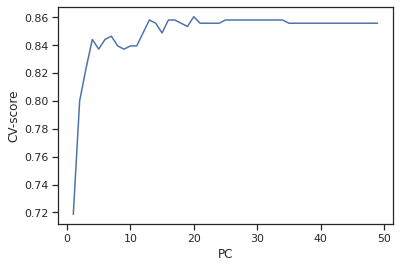

In [71]:
cv_scores_pca = []

# For all PCA dimensions, calculate the cross validation score
for i in range(1,50):
    pcai = PCA(i)
    components_i = pcai.fit_transform(training_data, training_labels['class2'])
    cv_scores_pca.append(cross_val_score(LogisticRegression(), components_i, training_labels['class2'], cv=10).mean())
    
# Plot cross validation score as a function of principal components used.
plt.plot(range(1, 50), cv_scores_pca)
plt.xlabel("PC")
plt.ylabel("CV-score")

In [73]:
# Print optimal cross validation score and corresponding amount of principal components
print('Best CV score:', np.max(cv_scores_pca), '| PC count:', np.argmax(cv_scores_pca))

Best CV score: 0.8604651162790697 | PC count: 19


Maximum cross validation score was achieved with 19 principal components at 0.86 which is only a minor improvement compared to the original cross-validation achieved by using all features (0.856). At this point, we would be inclined to go forward to model selection using all features. This shouldn't cause any harm since the number of features is still quite reasonable (only 50).

### Model selection

Model selection will be done using 10-fold cross validation to gather an unbiased estimation of the test set loss. The best scoring model will be used for the final classification.

Models to be compared: Logistic Regression, SVM Classifier, Naive Bayes, Random Forest Classifier and SGD classifier. All models will be tested with default hyper parameters. We get the following CV scores for the models:

In [81]:
# Calculate cross validation scores for all models
logreg_cv = cross_val_score(LogisticRegression(), training_data, training_labels['class2'], cv=10).mean()
svc_cv = cross_val_score(SVC(), training_data, training_labels['class2'], cv=10).mean()
nb_cv = cross_val_score(GaussianNB(), training_data, training_labels['class2'], cv=10).mean()
rfc_cv = cross_val_score(RandomForestClassifier(), training_data, training_labels['class2'], cv=10).mean()
sgd_cv = cross_val_score(SGDClassifier(), training_data, training_labels['class2'], cv=10).mean()

print(f"SVC:\t{svc_cv:.3f}")
print(f"RFC:\t{rfc_cv:.3f}")
print(f"LogReg:\t{logreg_cv:.3f}")
print(f"SGD:\t{sgd_cv:.3f}")
print(f"NB:\t{nb_cv:.3f}")

SVC:	0.893
RFC:	0.867
LogReg:	0.856
SGD:	0.823
NB:	0.814


Out of these models, SVC has the best cross validation score and the second best model was Random Forest classifier. Next, a quick check whether changing the regularization parameter of SVC or using a linear kernel would further increase the score for SVC.

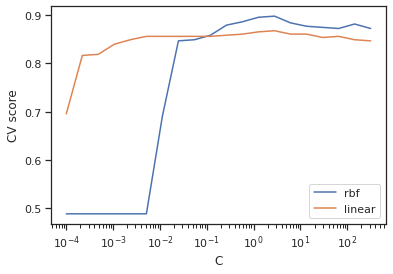

In [78]:
# Define the range for regularization parameter search
c_range = np.logspace(-4,2.5,20)
ctest_cv_scores = []
ctest_cv_scores_linear = []

for c in c_range:
    # For each parameter value C, compute the 10-fold cross validation score
    svci_cv = cross_val_score(SVC(C=c), training_data, training_labels['class2'], cv=10).mean()
    svci_cv_linear = cross_val_score(SVC(kernel="linear", C=c), training_data, training_labels['class2'], cv=10).mean()
    ctest_cv_scores.append(svci_cv)
    ctest_cv_scores_linear.append(svci_cv_linear)

plt.plot(c_range, ctest_cv_scores, label="rbf")
plt.plot(c_range, ctest_cv_scores_linear, label="linear")

plt.semilogx()
plt.ylabel("CV score")
plt.xlabel("C")
plt.legend()

In [80]:
print(f"Best regularization parameter C = {c_range[np.argmax(ctest_cv_scores)]:.3f} with a CV score of {np.max(ctest_cv_scores):.3f}")

Best regularization parameter C = 2.801 with a CV score of 0.898


According to the hyperparameter search, the best cross-validation score was achieved with a regularization paramater C = 2.801 using an rbf kernel.

#### Now, for the Random Forest Classifier. 

Another well-perfoming classifier in the first CV comparison was the Random Forest Classifier. We performed a grid search to see if some choice of hyperparameters would increase the accuracy.

In [82]:
### Build a parameter grid that will be used in the grid search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# This is a random grid search for best hyper-parameters.
# 20 random parameter combinations from the grid above will be used 
# The performance will be measured as the 5-fold cross-validation

grid = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid.fit(training_data, training_labels['class2'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.0s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

The best CV score and parameters for the random forest classifier were:

In [92]:
print('CV score:', grid.best_score_)
grid.best_params_

CV score: 0.8767441860465116


{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

Even when using the best parameters, the cross validation score is lower than with SVC. Thus, according to the cross validation scores, SVC seems to be the best model for this task using the rbf kernel and regularization parameter C = 2.801.

## Feature importance analysis with Random Forest Classifier

This part is just for curiosity as we already concluded that SVC is the best model for this problem. Conclusion of this part is that relative humidity and water concentration seem to be important in particle formation (of cource, relative humidity and water concentration are very much correlating). Random Forest algorithms have a handy feature importance property. Basically, it measures how much a certain feature affects the prediction. I will fit a random forest classifier and plot this feature importance to see which features seem important to the model.

Text(0, 0.5, 'Importance')

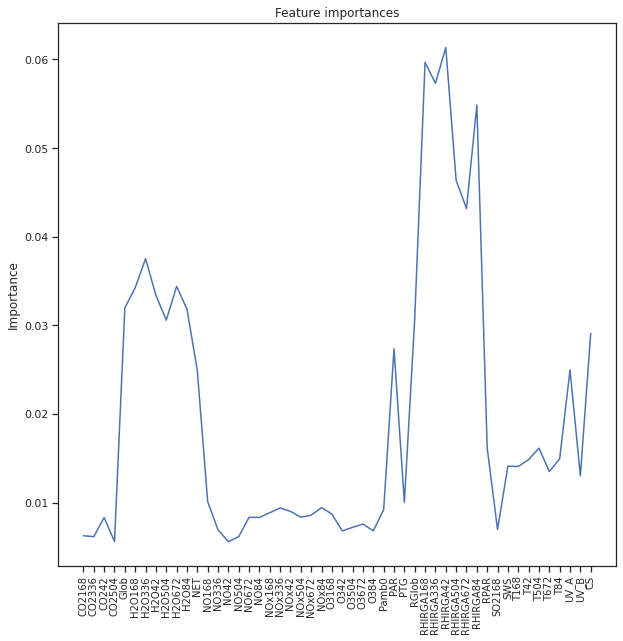

In [90]:
# Model is fitted using the best parameters found in the grid search above
model = RandomForestClassifier(**grid.best_params_)

model.fit(training_data, training_labels['class2'])

fig, ax = plt.subplots(1,1, figsize=(10,10))

# model.feature_importances_ contain the importances for each feature
ax.plot(range(0,50), model.feature_importances_)
ax.set_xticks(range(0, 50))
ax.set_xticklabels(training_data.columns, rotation='vertical', fontsize=10)
ax.set_title("Feature importances")
ax.set_ylabel("Importance")

The top 10 most important features are:

In [93]:
top10 = model.feature_importances_.argsort()[-10:][::-1]
print(', '.join(training_data.columns[top10].values))

RHIRGA42, RHIRGA168, RHIRGA336, RHIRGA84, RHIRGA504, RHIRGA672, H2O336, H2O672, H2O168, H2O42


These features also came up in selectKBest feature selection. The most important variables seem to be relative humidity (RHIRGA) and water concentration. Lets see how the CV score of an SVC model looks like with only these features:

In [29]:
print(f"All features: {cross_val_score(SVC(), X, y, cv=10).mean():.4f}")
print(f"Top 10:       {cross_val_score(SVC(), X.iloc[:,top10], y, cv=10).mean():.4f}")

All features: 0.8837
Top 10:       0.8674


There is a small less than 2% drop in the accuracy.

# Multi-Class Classifier

In [35]:
def preprosessing2(npf,scaler):
    '''Preprosessing function for npf_*.csv files'''

    # Dropping features 'partlybad','id' and 'date' because we won't need them. Feature 'partlybad' was only False 
    X = npf.drop(['date','id','partlybad','class4'],axis=1)
    

    #Dropping std's
    X_means = X.drop([c for c in npf.columns if 'std' in c],axis=1)


    # Removing .means from all column names
    cols = [col[:-5] for col in X_means.columns]

    # Normalizing for zero mean and unit variance
    X_means_np = scaler(X_means)

    #df = pd.DataFrame(X_means_np, columns=cols)
    #df["class4"] = npf["class4"]

    #return df
    X_means['class4'] = npf['class4']
    return X_means

def best_feature_columns(X_train, y_train, n):
    '''Return n best feature columns'''
    select = sklearn.feature_selection.SelectKBest(k=n)
    selected_features = select.fit(X_train, y_train)
    indices_selected = selected_features.get_support(indices=True)
    colnames_selected = [X_train.columns[i] for i in indices_selected]

    return colnames_selected

# Loading the data and doing some preprosessing.
npf = preprosessing2(npf_train,scale)
X_npf = npf.drop('class4',axis=1)

# Changing the categorical values to integers
y = npf['class4'].astype('category').cat.codes

# Scaling the data for zero mean and unit variance
# Removing .means from all column names
cols = [col[:-5] for col in X_npf.columns]

# Normalizing for zero mean and unit variance
X_np = scale(X_npf)

X = pd.DataFrame(X_np, columns=cols)

Selecting 20 best features

In [36]:
features = best_feature_columns(X,y,20)

/home/kopio/.local/share/virtualenvs/iml-term-project-VNmOTpJK/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Now doing the clustering. Fist using K-Means clustering. We set 4 clusters as parameter because we know that we have 4 classes to distinguish

In [37]:
kmeans_cluster = KMeans(4,n_init=50,random_state=3)
kmeans_cluster.fit(X)
#kmeans_cluster = KMeans(n_clusters=4, n_init=50,random_state=42).fit(X[features])


KMeans(n_clusters=4, n_init=50, random_state=3)

In [38]:
acc = accuracy_score(y, kmeans_cluster.labels_)
acc

0.11627906976744186

Hmm quite bad accuracy. The labels are probably permuted

In [39]:
import scipy
def find_permutation(n_clusters, real_labels, labels):
    permutation = []
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation

In [40]:
permutation = find_permutation(4,y,kmeans_cluster.labels_)
print(permutation)

[3, 3, 3, 0]


In [41]:
from collections import Counter
print(Counter(y).keys())
print(Counter(y).values())


dict_keys([3, 2, 0, 1])
dict_values([215, 83, 106, 26])


Hmm why it misses value 1?

In [42]:
new_labels = [ permutation[label] for label in kmeans_cluster.labels_]   # permute the labels
print("Accuracy score is", accuracy_score(y, new_labels))


Accuracy score is 0.6232558139534884


Let's do a confusion matrix to double check the results


In [43]:
df = pd.DataFrame({'Labels': y, 'Clusters':kmeans_cluster.labels_})
ct = pd.crosstab(df['Labels'],df['Clusters'])
ct

Clusters,0,1,2,3
Labels,,,,
0,33,10,0,63
1,2,7,0,17
2,22,6,0,55
3,91,111,3,10


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y,new_labels))

              precision    recall  f1-score   support

           0       0.43      0.59      0.50       106
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        83
           3       0.72      0.95      0.82       215

    accuracy                           0.62       430
   macro avg       0.29      0.39      0.33       430
weighted avg       0.47      0.62      0.53       430



/home/kopio/.local/share/virtualenvs/iml-term-project-VNmOTpJK/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Maybe trying different scaling or not scaling at all would help

In [45]:
X_minmax = pd.DataFrame(MinMaxScaler().fit_transform(X_npf), columns=X_npf.columns)
X_standard = pd.DataFrame(StandardScaler().fit_transform(X_npf), columns=X_npf.columns)
X_noscaling = X_npf

Feature selection

In [46]:
minmax_features = best_feature_columns(X_minmax,y,20)
standard_features = best_feature_columns(X_standard,y,20)
noscaling_features = best_feature_columns(X_noscaling,y,20)

/home/kopio/.local/share/virtualenvs/iml-term-project-VNmOTpJK/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/kopio/.local/share/virtualenvs/iml-term-project-VNmOTpJK/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/kopio/.local/share/virtualenvs/iml-term-project-VNmOTpJK/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [357]:
# Minmax scaling result

cluster = KMeans(4,n_init=50,random_state=42)
minmax_cluster = cluster.fit(X_minmax[minmax_features])
permutation = find_permutation(4,y,minmax_cluster.labels_)
new_labels = [ permutation[label] for label in minmax_cluster.labels_] 
print("Accuracy score is for MinMax scaling", accuracy_score(y, new_labels))
permutation

Accuracy score is for MinMax scaling 0.5651162790697675


[0, 0, 3, 3]

In [358]:
# Standard scaling result

cluster = KMeans(4,n_init=50,random_state=42)
stamdard_cluster = cluster.fit(X_standard[standard_features])
permutation = find_permutation(4,y,stamdard_cluster.labels_)
new_labels = [ permutation[label] for label in stamdard_cluster.labels_] 
print("Accuracy score is for Standard scaling", accuracy_score(y, new_labels))
permutation

Accuracy score is for Standard scaling 0.586046511627907


[2, 3, 0, 3]

In [359]:
# No scaling result

cluster = KMeans(4,n_init=50,random_state=42)
nofeatures_cluster = cluster.fit(X_noscaling[noscaling_features])
permutation = find_permutation(4,y,nofeatures_cluster.labels_)
new_labels = [ permutation[label] for label in nofeatures_cluster.labels_] 
print("Accuracy score is for no scaling", accuracy_score(y, new_labels))
permutation

Accuracy score is for no scaling 0.5790697674418605


[2, 3, 0, 3]

Well this is kind of odd? Class Ia is totally missing from the results? Let's try hieragical clustering

In [306]:
from sklearn.cluster import AgglomerativeClustering

# Zero mean and unit variance scaling
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean',linkage='ward')
data = X[features].values
cluster.fit(data)
permutation = find_permutation(4,y,cluster.labels_)
new_labels = [ permutation[label] for label in cluster.labels_] 
print("Accuracy score is for no scaling", accuracy_score(y, new_labels))
permutation

Accuracy score is for no scaling 0.5720930232558139


[3, 2, 3, 0]

In [307]:
# Minmax scaling
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean',linkage='ward')
data = X_minmax[minmax_features].values
cluster.fit(data)
permutation = find_permutation(4,y,cluster.labels_)
new_labels = [ permutation[label] for label in cluster.labels_] 
print("Accuracy score is for minmax scaling", accuracy_score(y, new_labels))
permutation

Accuracy score is for no scaling 0.586046511627907


[3, 0, 0, 2]

In [308]:
# Standard scaling
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean',linkage='ward')
data = X_standard[standard_features].values
cluster.fit(data)
permutation = find_permutation(4,y,cluster.labels_)
new_labels = [ permutation[label] for label in cluster.labels_] 
print("Accuracy score is for standard scaling", accuracy_score(y, new_labels))
permutation

Accuracy score is for no scaling 0.5720930232558139


[3, 2, 3, 0]

In [309]:
# No scaling
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean',linkage='ward')
data = X_noscaling[noscaling_features].values
cluster.fit(data)
permutation = find_permutation(4,y,cluster.labels_)
new_labels = [ permutation[label] for label in cluster.labels_] 
print("Accuracy score is for no scaling", accuracy_score(y, new_labels))
permutation

Accuracy score is for no scaling 0.5767441860465117


[3, 2, 3, 0]

Maybe it is just that it can't be predicted so well. I'd go with the k-means clustering. 

Last, let's try different amount of features. I will use StandardScaler as it got the best accuracy with most classes present

In [404]:
import random
random.seed(42)

best_score = 0
best_permu = []
n_features = 0
best_features = []
for i in range(1,len(X_noscaling.columns)):
    standard_features = best_feature_columns(X_standard,y,12)
    cluster = KMeans(4,n_init=50,random_state=i)
    standard_cluster = cluster.fit(X_standard[standard_features])
    permutation = find_permutation(4,y,standard_cluster.labels_)
    new_labels = [ permutation[label] for label in stamdard_cluster.labels_] 
    acc = accuracy_score(y, new_labels)

    if (acc > best_score):
        best_score = acc
        best_permu = permutation
        n_features = i
        best_features = standard_features

print("Best accuracy score is for {} features with acc of: {} the permutation being {}".format(n_features, best_score,best_permu))
print(best_features)
0.586046511627907

Best accuracy score is for 18 features with acc of: 0.586046511627907 the permutation being [2, 3, 0, 3]
['Glob.mean', 'NET.mean', 'PAR.mean', 'RGlob.mean', 'RHIRGA168.mean', 'RHIRGA336.mean', 'RHIRGA42.mean', 'RHIRGA504.mean', 'RHIRGA672.mean', 'RHIRGA84.mean', 'UV_A.mean', 'UV_B.mean']


0.586046511627907

In [405]:
n_features = 12
standard_features = best_feature_columns(X_standard,y,n_features)
cluster = KMeans(4,n_init=50,random_state=18)
standard_cluster = cluster.fit(X_standard[standard_features])
permutation = find_permutation(4,y,standard_cluster.labels_)
new_labels = [ permutation[label] for label in stamdard_cluster.labels_] 
acc = accuracy_score(y, new_labels)
print("ccuracy score is for {} features with acc of: {} the permutation being {}".format(n_features, acc,permutation))
standard_features

ccuracy score is for 12 features with acc of: 0.586046511627907 the permutation being [2, 3, 0, 3]


['Glob.mean',
 'NET.mean',
 'PAR.mean',
 'RGlob.mean',
 'RHIRGA168.mean',
 'RHIRGA336.mean',
 'RHIRGA42.mean',
 'RHIRGA504.mean',
 'RHIRGA672.mean',
 'RHIRGA84.mean',
 'UV_A.mean',
 'UV_B.mean']

Trying some supervised learning now
 -Logistic regression

In [425]:
# X being X_standard which is just standard scaled X values
y = npf['class4']

# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X_standard, y, random_state=42)

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.71
Accuracy of Logistic regression classifier on test set: 0.70


Trying the same with best 12 features

In [413]:
features = ['Glob.mean',
 'NET.mean',
 'PAR.mean',
 'RGlob.mean',
 'RHIRGA168.mean',
 'RHIRGA336.mean',
 'RHIRGA42.mean',
 'RHIRGA504.mean',
 'RHIRGA672.mean',
 'RHIRGA84.mean',
 'UV_A.mean',
 'UV_B.mean']

In [424]:


X_train, X_test, y_train, y_test = train_test_split(X_standard[features], y, random_state=42)

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.62
Accuracy of Logistic regression classifier on test set: 0.66


Oh, worse score. Maybe well just include all features. Let's try Decission Tree next

In [416]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_standard, y, random_state=42)

clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.64


In [417]:
# K neighbour classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.75
Accuracy of K-NN classifier on test set: 0.67


In [418]:
# Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.76
Accuracy of LDA classifier on test set: 0.64


In [419]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.56
Accuracy of GNB classifier on test set: 0.55


In [426]:
# SVM

from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.73
Accuracy of SVM classifier on test set: 0.70


## SVM and logistic regression gave the best accuracies

In [427]:
# This is for logreg

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = logreg.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[17  0  1  5]
 [ 3  0  0  1]
 [13  3  5  4]
 [ 1  0  1 54]]
              precision    recall  f1-score   support

          II       0.50      0.74      0.60        23
          Ia       0.00      0.00      0.00         4
          Ib       0.71      0.20      0.31        25
    nonevent       0.84      0.96      0.90        56

    accuracy                           0.70       108
   macro avg       0.51      0.48      0.45       108
weighted avg       0.71      0.70      0.67       108



In [428]:
# This is for SVM

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[15  0  4  4]
 [ 2  0  0  2]
 [16  0  6  3]
 [ 1  0  0 55]]
              precision    recall  f1-score   support

          II       0.44      0.65      0.53        23
          Ia       0.00      0.00      0.00         4
          Ib       0.60      0.24      0.34        25
    nonevent       0.86      0.98      0.92        56

    accuracy                           0.70       108
   macro avg       0.48      0.47      0.45       108
weighted avg       0.68      0.70      0.67       108



## Thought process

Data preprocessing  
    - Dropped std's  
    - Used various different scaling types to see if there is a difference

In every machine learning method 4 clusters was selected as paremeter because we know that we have 4 different event to distinguish

### Unsupervised learning methods  

- K-means  
    * Changed categorical labels to integers  
    * Scaled data to zero mean and unit variance
    * Selected 20 best feature with skleanr selectKBest()  
    * Score after permutation was 0.60, but only events of II and nonevent was distinguished  
    * Next I tried to do the same with different scaling methods  
        - MinMaxScaler, StandardScaler and no scaling at all  
    MinMax:     acc = 0.565  
    Standard:   acc = 0.586
    NoScaling:  acc = 0.576  

- Hierachical clustering  
    * I performed the same test with AgglomerativeClustering to see if this unsupervised method performs better

    Scale:      acc = 0.572
    MinMax:     acc = 0.586
    Standard:   acc = 0.572
    NoScaling:  acc = 0.576

    * So no development here
    * Lastly I tried k-means with StandardScaler, as it had the best accuracy while most of the classes were present, and different amount of features.  

    There was no clear trend but with the binay classifier 12 features were the best to I tried it also and the result was not significantly better.  


### Supervised learning methods

Same preprosessing of the data except I didn't categorizise the labels and used only Standard scaler. Tested just a bunch of different supervised learning methods. Started with Logistic regression  

- Logistic regression  
    * Data splitted in 75/25 ratio to train and test
    * Acc score = 0.70 on test set
    * Tried to reduce the amount of features to 12 best but it lowered the accuracy  
        - Acc score = 0.66 (12 features)
    * Decided to keep all the features along
- Next just test different methods (all acc scores on test set)

    Decission there                 acc = 0.64
    K-NN                            acc = 0.67
    Linear discriminant analysis    acc = 0.64
    Gaussia NB                      acc = 0.55
    SVM                             acc = 0.70  

- LogReg and SVM turned out to be the best from all supervised and unsupervised learning methods, but I chose LogReg to be the best. That is because it's weighted average and the recall values turned out to be a little better than SVM's



    


# Conclusions

Best model for binary classifiaction seems to be SVC with rbf kernel and C=2.801. For multi-class classification a linear regression model was used.

To achieve better accuracy, the standard deviation values could be considered as well.


# Group Work

Detailed summary about the group work will be in the finalized version.